<a href="https://colab.research.google.com/github/Jeeeeeeeee/Jwith9Es/blob/main/credit_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 67.4 MB 27 kB/s 
     |████████████████████████████████| 80 kB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action = 'ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool

In [ ]:
train_path = '/content/drive/MyDrive/credit_train.csv'
test_path = '/content/drive/MyDrive/credit_test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

label = train['credit']

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
# # 불필요한 컬럼 제거
# train.drop(columns = ['index', 'credit'], inplace = True)
# test.drop(columns = 'index', inplace = True)

# 전처리
참고 문헌(1위 팀 소회의실 님 코드공유) : https://www.dacon.io/competitions/official/235713/codeshare/2768?page=1&dtype=recent

In [ ]:
# catboost 단독모델할거면 이렇게 해야함

train.drop(columns = 'index', inplace = True)
test.drop(columns = 'index', inplace = True)

In [ ]:
# 이상치 처리

train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop = True)

In [ ]:
# 의미없는 변수 제거
train.drop([ 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop([ 'FLAG_MOBIL'], axis=1, inplace=True)

# DAYS_EMPLOYED 무직자
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

# 음수 칼럼 양수 변환
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

# 파생변수
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: 소득/(살아온 일수+ 근무일수)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: 소득/ 가족 수
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


# 파생변수와 다중공선을 보이는 칼럼 삭제
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))
cat_cols = categorical_feats

Number of Numerical features:  18
Number of Categorical features:  9


In [ ]:
# income_total에 대해 로그 스케일
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

# 카테고리 변수 ordinal encoding
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

# ID 변환 후 정수 처리
train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

# numerical columns에 대해 정규화
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
from sklearn.model_selection import train_test_split

random_seed = 42

x_train, x_valid, y_train, y_valid = train_test_split(train, train['credit'],
                                                      test_size = 0.3,
                                                      random_state = random_seed,
                                                      shuffle = True,
                                                      stratify = train['credit'])

catboost 단독모델 feature_importance 확인

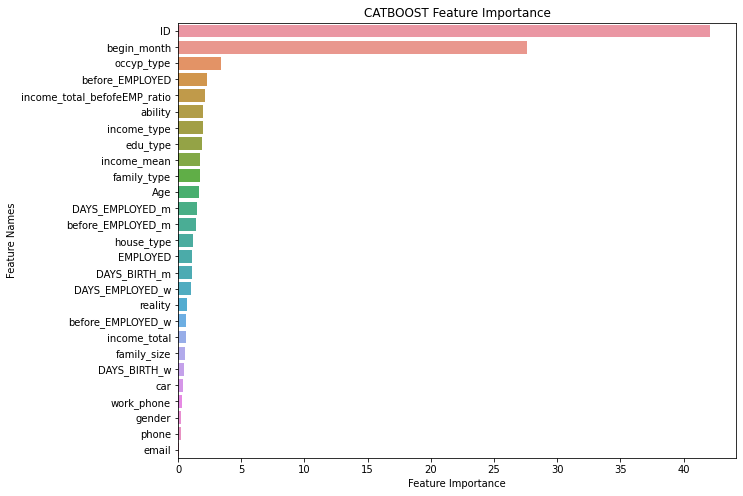

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
!pip install optuna

     |████████████████████████████████| 302 kB 7.4 MB/s 
     |████████████████████████████████| 164 kB 59.2 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 75 kB 5.4 MB/s 
     |████████████████████████████████| 141 kB 57.5 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
     |████████████████████████████████| 111 kB 64.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2444e35359e46ba54b81c01de362abdf889f1d2e4a85d53afb83120e29f40b77
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# xgboost hyperparameters optuna tuning

In [ ]:
from xgboost import XGBClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss

In [ ]:
def objective(trial: Trial) -> float:
  params_xgb = {
      "random_state" : 42,
      # "eval_metric" : "logloss",
      "learning_rate" : 0.3,
      "n_estimators" : 10000,
      "gamma" : trial.suggest_float("gamma", 1, 15),
      "max_depth" : trial.suggest_int("max_depth", 10, 30),
      "min_child_weight" : trial.suggest_float("min_child_weight", 150, 300.),
      "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
      # "reg_lambda" : trial.suggest_float("reg_lambda", 1e-8, 9e-2 ),
      # "reg_alpha" : trial.suggest_float("reg_alpha", 1e-8, 3e-5),
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 5),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 5),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
      # "max_bin": trial.suggest_int("max_bin", 200, 500),

  }
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

  model = XGBClassifier(**params_xgb)
  model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds = 100, verbose = False)
  

  xgb_pred = model.predict_proba(X_valid)
  log_score = log_loss(y_valid, xgb_pred)

  return log_score

In [ ]:
sampler = TPESampler(seed = 42)
study = optuna.create_study(
    study_name = "xgb_parameter_opt",
    direction = "minimize",
    sampler = sampler,
)

study.optimize(objective, n_trials = 10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-08-09 21:10:26,595] A new study created in memory with name: xgb_parameter_opt


KeyboardInterrupt: ignored

# lightGBM Optuna

In [ ]:
from lightgbm import LGBMClassifier

def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10) # optimize 10번 해본다는 뜻
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

# 1회차 테스트사이즈 0.2 0.695210826
# 2회차 뻘짓 0.72
# 3회차 테스트사이즈 0.3 0.7043
# 4회차 테스트사이즈 0.25 0.69987
# 5회차 테스트사이즈 0.15 0.675094
# 6회차 테스트사이즈 0.1 0.695489-> trial마다 편차가 꽤 컸다. < 여기서 오버피팅되는 것 같은.. ;ㅅ;
# 7회차 n_estimators = 1000 0.7094

[I 2021-08-09 21:10:42,743] A new study created in memory with name: lgbm_parameter_opt
[I 2021-08-09 21:10:55,520] Trial 0 finished with value: 0.7157225654620238 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7157225654620238.
[I 2021-08-09 21:11:04,453] Trial 1 finished with value: 0.715032381957376 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.715032381957376.
[I 2021-08-09 21:11:20,752] Trial 2 finished with value: 0.7094904227768938 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambda'

Best Score: 0.7094904227768938
Best trial: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambda': 0.02621062970553237, 'max_depth': 13, 'num_leaves': 37, 'colsample_bytree': 0.5752867891211308, 'subsample': 0.5564532903055841, 'subsample_freq': 5, 'min_child_samples': 80, 'max_bin': 260}


In [ ]:
params_best = {
    "random_state": 42,
    "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 10000,
    "objective": "multiclass",
    "metric": "multi_logloss",
    # 'reg_alpha': 2.1245096608103405e-05, 
    # 'reg_lambda': 0.0018526142807772773, 
    # 'max_depth': 20, 
    # 'num_leaves': 214, 
    # 'colsample_bytree': 0.5274034664069657, 
    # 'subsample': 0.42727747704497043, 
    # 'subsample_freq': 2, 
    # 'min_child_samples': 34, 
    # 'max_bin': 357
    'reg_alpha': 1.7560829253683595e-07, 
    'reg_lambda': 0.07339153040632079, 
    'max_depth': 15, 
    'num_leaves': 187, 
    'colsample_bytree': 0.8627622080115674, 
    'subsample': 0.35183125621386324, 
    'subsample_freq': 4, 
    'min_child_samples': 16, 
    'max_bin': 459
}

model = LGBMClassifier(**params_best) # 와 여기 별표 두개 꼭 붙여야 된다고 함..
model.fit(X_train,
          y_train,
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          early_stopping_rounds=100,
          verbose = False
    )

lgb_pred = model.predict_proba(test)

In [ ]:
lgb_pred

array([[0.05534331, 0.23841373, 0.70624296],
       [0.2495521 , 0.44317024, 0.30727766],
       [0.03399918, 0.04374156, 0.92225926],
       ...,
       [0.02122323, 0.12652429, 0.85225247],
       [0.16235884, 0.36315435, 0.47448682],
       [0.03214312, 0.2976241 , 0.67023278]])

In [ ]:
submit_path = '/content/drive/MyDrive/sample_submission.csv'

submit = pd.read_csv(submit_path)

In [ ]:
submit.iloc[:, 1:] = lgb_pred
submit

,index,0,1,2
0,26457,0.055343,0.238414,0.706243
1,26458,0.249552,0.443170,0.307278
2,26459,0.033999,0.043742,0.922259
3,26460,0.091147,0.111398,0.797455
4,26461,0.052540,0.211649,0.735811
...,...,...,...,...
9995,36452,0.037398,0.160654,0.801948
9996,36453,0.295654,0.358853,0.345493
9997,36454,0.021223,0.126524,0.852252
9998,36455,0.162359,0.363154,0.474487


In [ ]:
submit.to_csv('lgb_pred_optuna_second.csv', index=False)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

# Stacking - lgbm , xgb

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

n_splits=15
    
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# lgbm_params = {
#     "random_state": 42,
#     # "verbosity": -1,
#     "learning_rate": 0.05,
#     "n_estimators": 10000,
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     'reg_alpha': 2.1245096608103405e-05, 
#     'reg_lambda': 0.0018526142807772773, 
#     'max_depth': 20, 
#     'num_leaves': 214, 
#     'colsample_bytree': 0.5274034664069657, 
#     'subsample': 0.42727747704497043, 
#     'subsample_freq': 2, 
#     'min_child_samples': 34, 
#     'max_bin': 357}

# lgbm_params_2 = {    
#     "random_state": 42,
#     # "verbosity": -1,
#     "learning_rate": 0.05,
#     "n_estimators": 10000,
#     "objective": "multiclass",
#     "metric": "multi_logloss",
#     'reg_alpha': 1.7560829253683595e-07, 
#     'reg_lambda': 0.07339153040632079, 
#     'max_depth': 15, 
#     'num_leaves': 187, 
#     'colsample_bytree': 0.8627622080115674, 
#     'subsample': 0.35183125621386324, 
#     'subsample_freq': 4, 
#     'min_child_samples': 16, 
#     'max_bin': 459}



val_scores = list()
# 결과 값들을 stacking 해야하기 때문에, (모델 개수, 샘플의 수, 3) 라는 차원으로 구성됩니다.
oof_train = np.zeros((6, train.shape[0], 3))
oof_test  = np.zeros((6, test.shape[0], 3))

# oof_pred  = np.zeros((test.shape[0], 3))

for i, (trn_idx, val_idx) in enumerate(skf.split(train, label)):
    x_train, y_train = train.iloc[trn_idx, :], label.iloc[trn_idx,]
    x_valid, y_valid = train.iloc[val_idx, :], label.iloc[val_idx,]

    
    # 모델 정의
    models = [
              XGBClassifier(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
              XGBClassifier(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1),
              # XGBClassifier(**lgbm_params, n_jobs = -1),
              # XGBClassifier(**lgbm_params_2, n_jobs = -1),
              CatBoostClassifier(cat_features=cat_cols),
              CatBoostClassifier(cat_features=cat_cols),
              LGBMClassifier(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
              LGBMClassifier(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1)]
            
    for j, model in enumerate(models):
        # 모델 학습
        model.fit(x_train, y_train)

        # j번째 칸에 맞는 결과 담기.
        oof_train[j, val_idx, ] += model.predict_proba(x_valid)
        oof_test[j, :, ]        += model.predict_proba(x_test) / n_splits
    
    print(f'{i} Fold, ...')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
7:	learn: 0.8766107	total: 693ms	remaining: 1m 25s
8:	learn: 0.8668381	total: 749ms	remaining: 1m 22s
9:	learn: 0.8577105	total: 879ms	remaining: 1m 27s
10:	learn: 0.8367518	total: 984ms	remaining: 1m 28s
11:	learn: 0.8191895	total: 1.08s	remaining: 1m 29s
12:	learn: 0.8048206	total: 1.17s	remaining: 1m 28s
13:	learn: 0.8004281	total: 1.24s	remaining: 1m 27s
14:	learn: 0.7967587	total: 1.32s	remaining: 1m 26s
15:	learn: 0.7860004	total: 1.43s	remaining: 1m 27s
16:	learn: 0.7762361	total: 1.53s	remaining: 1m 28s
17:	learn: 0.7689305	total: 1.64s	remaining: 1m 29s
18:	learn: 0.7615269	total: 1.73s	remaining: 1m 29s
19:	learn: 0.7568106	total: 1.83s	remaining: 1m 29s
20:	learn: 0.7515315	total: 1.91s	remaining: 1m 29s
21:	learn: 0.7464234	total: 1.99s	remaining: 1m 28s
22:	learn: 0.7432474	total: 2.1s	remaining: 1m 29s
23:	learn: 0.7395024	total: 2.19s	remaining: 1m 28s
24:	learn: 0.7370485	total: 2.26s	remaining: 1m 28s
25:	learn: 0.7352064	total: 2.38

In [ ]:
# ERROR : Found input variables with inconsistent numbers of samples: [26451, 26457] 휴 그만좀 보자 ㅠ
x_test = test
train2 = train.copy(deep = True)
label = train['credit']
train.drop(columns = 'credit', inplace = True)

In [ ]:
# 모은 train, test의 예측 값을 new_x_train, new_x_test로 사용합니다.
new_train = pd.DataFrame(np.concatenate(oof_train, axis=1))
new_test  = pd.DataFrame(np.concatenate(oof_test, axis=1))

In [ ]:
from sklearn.preprocessing import StandardScaler

val_scores = list()
oof_pred  = np.zeros((test.shape[0], 3))

for i, (trn_idx, val_idx) in enumerate(skf.split(new_train, label)):
    x_train, y_train = new_train.iloc[trn_idx, :], label[trn_idx]
    x_valid, y_valid = new_train.iloc[val_idx, :], label[val_idx]
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train     = scaler.transform(x_train)
    x_valid     = scaler.transform(x_valid)
    new_x_test  = scaler.transform(new_test)

    # 모델 정의
    model = XGBClassifier(n_estimators=10000,
                          n_jobs=-1)
    
    # 모델 학습
    model.fit(x_train, y_train,
              eval_set=[[x_train, y_train], [x_valid, y_valid]],
              eval_metric='mlogloss',
              early_stopping_rounds=100,
              verbose=100)

    # 훈련, 검증 데이터 log_loss 확인
    trn_logloss = log_loss(y_train, model.predict_proba(x_train))
    val_logloss = log_loss(y_valid, model.predict_proba(x_valid))
    print('{} Fold, train logloss : {:.4f}4, validation logloss : {:.4f}'.format(i, trn_logloss, val_logloss))
    
    val_scores.append(val_logloss)
    
    # 반드시 log의 역함수인 exp를 취해주세요.
    oof_pred += model.predict_proba(new_x_test) / n_splits
    

# 교차 검증 log loss 평균 계산하기
print('Cross Validation Score : {:.5f}'.format(np.mean(val_scores)))

[0]	validation_0-mlogloss:1.03823	validation_1-mlogloss:1.03861
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.656972	validation_1-mlogloss:0.679393
Stopping. Best iteration:
[85]	validation_0-mlogloss:0.660164	validation_1-mlogloss:0.678936

0 Fold, train logloss : 0.66024, validation logloss : 0.6789
[0]	validation_0-mlogloss:1.03806	validation_1-mlogloss:1.03924
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.655821	validation_1-mlogloss:0.67925
Stopping. Best iteration:
[72]	validation_0-mlogloss:0.661927	validation_1-mlogloss:0.678808

1 Fold, train logloss : 0.66194, validation logloss : 0.6788
[0]	validation_0-mlogloss:1.038	validation_1-mlogloss:1.03853
Multiple eval metrics have be

In [ ]:
submit_path = '/content/drive/MyDrive/sample_submission.csv'
submit = pd.read_csv(submit_path)

In [ ]:
submit.iloc[:, 1:] = oof_pred
submit

,index,0,1,2
0,26457,0.110766,0.210545,0.678688
1,26458,0.267040,0.287805,0.445155
2,26459,0.040126,0.076229,0.883645
3,26460,0.091140,0.104342,0.804518
4,26461,0.089744,0.189918,0.720339
...,...,...,...,...
9995,36452,0.075994,0.205432,0.718574
9996,36453,0.284470,0.230720,0.484810
9997,36454,0.053749,0.138725,0.807526
9998,36455,0.119778,0.295838,0.584385


In [ ]:
submit.to_csv('cat_xgb_lgbm_oof_stacking''.csv', index=False)

### optuna를 이용한 하이퍼파라미터 조정

In [ ]:
# ERROR : Found input variables with inconsistent numbers of samples: [26451, 26457] 휴 그만좀 보자 ㅠ
x_test = test
train2 = train.copy(deep = True)
label = train['credit']
train.drop(columns = 'credit', inplace = True)

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

n_splits=15
    
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

lgbm_params = {
    "random_state": 42,
    # "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 10000,
    "objective": "multiclass",
    "metric": "multi_logloss",
    'reg_alpha': 2.1245096608103405e-05, 
    'reg_lambda': 0.0018526142807772773, 
    'max_depth': 20, 
    'num_leaves': 214, 
    'colsample_bytree': 0.5274034664069657, 
    'subsample': 0.42727747704497043, 
    'subsample_freq': 2, 
    'min_child_samples': 34, 
    'max_bin': 357}

lgbm_params_2 = {    
    "random_state": 42,
    # "verbosity": -1,
    "learning_rate": 0.05,
    "n_estimators": 10000,
    "objective": "multiclass",
    "metric": "multi_logloss",
    'reg_alpha': 1.7560829253683595e-07, 
    'reg_lambda': 0.07339153040632079, 
    'max_depth': 15, 
    'num_leaves': 187, 
    'colsample_bytree': 0.8627622080115674, 
    'subsample': 0.35183125621386324, 
    'subsample_freq': 4, 
    'min_child_samples': 16, 
    'max_bin': 459}



val_scores = list()
# 결과 값들을 stacking 해야하기 때문에, (모델 개수, 샘플의 수, 3) 라는 차원으로 구성됩니다.
oof_train = np.zeros((6, train.shape[0], 3))
oof_test  = np.zeros((6, test.shape[0], 3))

# oof_pred  = np.zeros((test.shape[0], 3))

for i, (trn_idx, val_idx) in enumerate(skf.split(train, label)):
    x_train, y_train = train.iloc[trn_idx, :], label.iloc[trn_idx,]
    x_valid, y_valid = train.iloc[val_idx, :], label.iloc[val_idx,]

    
    # 모델 정의
    models = [
              # XGBClassifier(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
              # XGBClassifier(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1),
              XGBClassifier(**lgbm_params, n_jobs = -1),
              XGBClassifier(**lgbm_params_2, n_jobs = -1),
              CatBoostClassifier(cat_features=cat_cols),
              CatBoostClassifier(cat_features=cat_cols),
              LGBMClassifier(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
              LGBMClassifier(n_estimators=150, max_depth=8, random_state=42, n_jobs=-1)]
            
    for j, model in enumerate(models):
        # 모델 학습
        model.fit(x_train, y_train)

        # j번째 칸에 맞는 결과 담기.
        oof_train[j, val_idx, ] += model.predict_proba(x_valid)
        oof_test[j, :, ]        += model.predict_proba(x_test) / n_splits
    
    print(f'{i} Fold, ...')

In [ ]:
# 모은 train, test의 예측 값을 new_x_train, new_x_test로 사용합니다.
new_train = pd.DataFrame(np.concatenate(oof_train, axis=1))
new_test  = pd.DataFrame(np.concatenate(oof_test, axis=1))

In [ ]:
from sklearn.preprocessing import StandardScaler

val_scores = list()
oof_pred  = np.zeros((test.shape[0], 3))

for i, (trn_idx, val_idx) in enumerate(skf.split(new_train, label)):
    x_train, y_train = new_train.iloc[trn_idx, :], label[trn_idx]
    x_valid, y_valid = new_train.iloc[val_idx, :], label[val_idx]
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train     = scaler.transform(x_train)
    x_valid     = scaler.transform(x_valid)
    new_x_test  = scaler.transform(new_test)

    # 모델 정의
    model = XGBClassifier(n_estimators=10000,
                          n_jobs=-1)
    
    # 모델 학습
    model.fit(x_train, y_train,
              eval_set=[[x_train, y_train], [x_valid, y_valid]],
              eval_metric='mlogloss',
              early_stopping_rounds=100,
              verbose=100)

    # 훈련, 검증 데이터 log_loss 확인
    trn_logloss = log_loss(y_train, model.predict_proba(x_train))
    val_logloss = log_loss(y_valid, model.predict_proba(x_valid))
    print('{} Fold, train logloss : {:.4f}4, validation logloss : {:.4f}'.format(i, trn_logloss, val_logloss))
    
    val_scores.append(val_logloss)
    
    # 반드시 log의 역함수인 exp를 취해주세요.
    oof_pred += model.predict_proba(new_x_test) / n_splits
    

# 교차 검증 log loss 평균 계산하기
print('Cross Validation Score : {:.5f}'.format(np.mean(val_scores)))